## Lab 4 - part 2: Data Weights and Autocorellation

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>



## Exercise 4a: Spatial Autocorrelation and ESDA 

USE the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?

In [1]:
# make sure we have all the plug ins I need for the exercises.

%matplotlib inline
import seaborn as sns
import pandas as pd
import pysal as ps
from pysal.explore import esda
from pysal.lib import weights
from libpysal.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import contextily as ctx

c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32844 entries, E01000001 to E01033768
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lsoa11cd    32844 non-null  object  
 1   lsoa11nm    32844 non-null  object  
 2   lsoa11nmw   32844 non-null  object  
 3   st_areasha  32844 non-null  float64 
 4   st_lengths  32844 non-null  float64 
 5   IMD_Rank    32844 non-null  int64   
 6   IMD_Decile  32844 non-null  int64   
 7   LSOA01NM    32844 non-null  object  
 8   LADcd       32844 non-null  object  
 9   LADnm       32844 non-null  object  
 10  IMDScore    32844 non-null  float64 
 11  IMDRank0    32844 non-null  int64   
 12  IMDDec0     32844 non-null  int64   
 13  IncScore    32844 non-null  float64 
 14  IncRank     32844 non-null  int64   
 15  IncDec      32844 non-null  int64   
 16  EmpScore    32844 non-null  float64 
 17  EmpRank     32844 non-null  int64   
 18  EmpDec      32844 non-null  int

<Axes: >

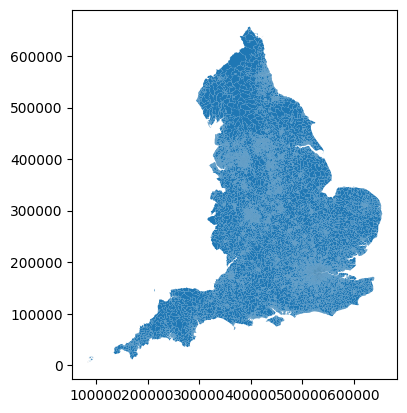

In [2]:
# QUESTION 1: reads in shapefile of polygons from LIVERPOOL
Liverpool_imd = 'C:\\Users\\natha\\Downloads\\lab-04\\data\\IMD\\IMD\\lab04_imd.shp'
lookup_path = 'C:\\Users\\natha\\Downloads\\lab-04\\data\\IMD\\IMD\\OAs'

Liverpool = gpd.read_file(Liverpool_imd).set_index('lsoa11cd', drop=False)

Liverpool.info()
Liverpool.plot()

In [3]:
Liverpool.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rank,IMD_Decile,LSOA01NM,LADcd,LADnm,...,IndDec,OutScore,OutRank,OutDec,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,geometry
lsoa11cd,,,,,,,,,,,,,,,,,,,,,
E01000001,E01000001,City of London 001A,City of London 001A,133320.768872,2291.846072,29199,9,City of London 001A,E09000001,City of London,...,5,1.503,1615,1,1296,175,656,465,715.00,"POLYGON ((532105.092 182011.23, 532162.491 181..."
E01000002,E01000002,City of London 001B,City of London 001B,226191.272990,2433.960112,30379,10,City of London 001B,E09000001,City of London,...,7,1.196,2969,1,1156,182,580,394,619.75,"POLYGON ((532746.813 181786.891, 532671.688 18..."
E01000003,E01000003,City of London 001C,City of London 001C,57302.966538,1142.359799,14915,5,City of London 001C,E09000001,City of London,...,6,2.207,162,1,1350,146,759,445,804.00,"POLYGON ((532135.145 182198.119, 532158.25 182..."
E01000005,E01000005,City of London 001E,City of London 001E,190738.760504,2167.868343,8678,3,City of London 001E,E09000001,City of London,...,8,1.769,849,1,1121,229,692,200,683.00,"POLYGON ((533807.946 180767.77, 533649.063 180..."
E01000006,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,144195.846857,1935.510354,14486,5,Barking and Dagenham 016A,E09000002,Barking and Dagenham,...,5,0.969,4368,2,2040,522,1297,221,1284.50,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [4]:
# QUESTION 1: Construct a Contiguity-Based Weight Matrix
w_queen = weights.Queen.from_dataframe(Liverpool, idVariable='lsoa11cd')
w_queen

C:\Users\natha\AppData\Local\Temp\ipykernel_9236\3623018862.py:2: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w_queen = weights.Queen.from_dataframe(Liverpool, idVariable='lsoa11cd')
c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There is 1 island with id: E01019077.
  W.__init__(self, neighbors, ids=ids, **kw)


In [5]:
# QUESTION 1: Return the weight matrix
w_queen['E01006690']

{'E01033763': 1.0,
 'E01006697': 1.0,
 'E01006691': 1.0,
 'E01006692': 1.0,
 'E01006695': 1.0,
 'E01006759': 1.0,
 'E01006720': 1.0}

In [6]:
# Islands will be challenging to work with throughout the analysis.
# w_queen.islands       # I ran this to confirm if there is an island in the data

Liverpool = Liverpool.drop(w_queen.islands)

In [7]:
# Must re-calculate the weight matrix now that the island has been removed.
w_queen = weights.Queen.from_dataframe(Liverpool, idVariable='lsoa11cd')
w_queen

C:\Users\natha\AppData\Local\Temp\ipykernel_9236\2218975776.py:2: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w_queen = weights.Queen.from_dataframe(Liverpool, idVariable='lsoa11cd')
c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [8]:
# Question 2: Calculate Moran's I
mi = esda.Moran(Liverpool['IMD_Rank'], w_queen)
mi.I

np.float64(0.5895602570187034)

In [9]:
# QUESTION 3: Standardizing Spatial Matrices

w_queen.transform = 'R'

In [10]:
# QUESTION 3: return the standardized weight matrix - results should be decimals instead of Boolean
w_queen['E01006690']

{'E01033763': 0.14285714285714285,
 'E01006697': 0.14285714285714285,
 'E01006691': 0.14285714285714285,
 'E01006692': 0.14285714285714285,
 'E01006695': 0.14285714285714285,
 'E01006759': 0.14285714285714285,
 'E01006720': 0.14285714285714285}

In [14]:
# QUESTION 4: Distance Based Weights

w_10km_dist = weights.DistanceBand.from_dataframe(Liverpool, 10000, binary=False)

c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
 There are 7 islands with ids: E01019229, E01019305, E01019325, E01027447, E01027479, E01027503, E01027585.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
 There are 7 islands with ids: E01019229, E01019305, E01019325, E01027447, E01027479, E01027503, E01027585.
  W.__init__(


In [15]:
w_10km_dist['E01006690'] # long output - many neighbours

{'E01006412': 0.0001664461364486456,
 'E01006413': 0.00016316788230951544,
 'E01006414': 0.0001732452640606962,
 'E01006415': 0.00012941412358354748,
 'E01006416': 0.00011797388461136008,
 'E01006417': 0.00012582153259262555,
 'E01006418': 0.00013127129805126932,
 'E01006419': 0.0001245449729609161,
 'E01006420': 0.00010194260606550699,
 'E01006421': 0.00013091159399963707,
 'E01006422': 0.00011466898466139244,
 'E01006423': 0.0001206469722419842,
 'E01006424': 0.00011876530224518804,
 'E01006425': 0.00013315458461018493,
 'E01006426': 0.00011261243032402919,
 'E01006427': 0.00011760172285629583,
 'E01006428': 0.00010176329459661787,
 'E01006429': 0.00010717055048462446,
 'E01006430': 0.00013106780510999165,
 'E01006431': 0.00012368616154027044,
 'E01006432': 0.00011426263315131452,
 'E01006433': 0.0001383950266734748,
 'E01006434': 0.00011563145774183125,
 'E01006435': 0.0001200696561671895,
 'E01006436': 0.00011196665029131524,
 'E01006437': 0.00011163133851007829,
 'E01006438': 0.00

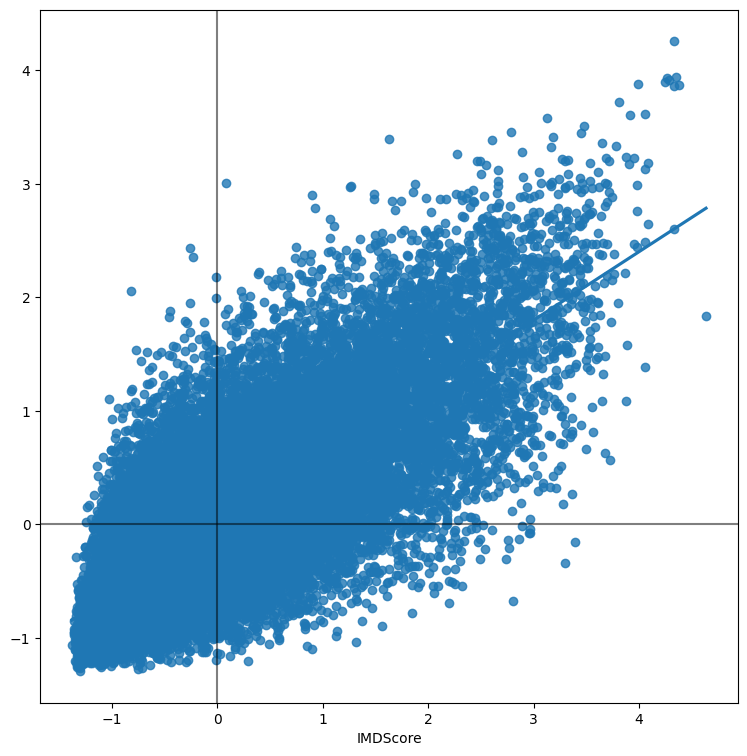

In [12]:
# QUESTION 5: Visualize a Moran plot

# Row-standardize the queen matrix
w_queen.transform = 'R'
# Compute spatial lag of `imd_score`
w_queen_score = weights.lag_spatial(w_queen, Liverpool['IMDScore'])
# Print the first five elements
w_queen_score[:5]

Liverpool['w_queen_score'] = w_queen_score

# Standardize the IMD scores
std_imd = (Liverpool['IMDScore'] - Liverpool['IMDScore'].mean()) / Liverpool['IMDScore'].std()
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
std_w_imd = pd.Series(weights.lag_spatial(w_queen, std_imd), index=std_imd.index)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_imd, y=std_w_imd, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

For this part I would like you to experiment with Data from Amstedam. However this will require you to find the dataset yourself!

## Question 1: Building a Contiguity-Based Weight Matrix

Use PySAL to create a contiguity-based weight matrix (W) for a given spatial dataset of polygons. Write a function create_contiguity_weights that:

    Reads in a shapefile of polygons.
    Constructs a Queen contiguity-based spatial weights matrix.
    Returns the weight matrix.

## Question 2: Calculating Moran’s I

Write a function calculate_morans_i that:

    Takes a spatial weight matrix W and an attribute array y.
    Calculates Moran’s I for the given attribute array.
    Returns the Moran’s I value and its p-value.

## Question 3: Standardizing Spatial Weight Matrices

Create a function standardize_weights that:

    Takes a spatial weight matrix W.
    Standardizes it so that the weights of each row sum to one.
    Returns the standardized weight matrix.

## Question 4: Creating Distance-Based Weights

Write a function create_distance_weights that:

    Takes a set of point coordinates and a threshold distance.
    Constructs a distance-based spatial weight matrix where all points within the threshold distance are assigned a weight.
    Returns the weight matrix.

## Question 5: Visualizing a Moran Plot

Using PySAL, write a function plot_moran that:

    Takes a spatial weights matrix W and an attribute array y.
    Creates and displays a Moran plot for the attribute.
    Saves the Moran plot as an image file.

In [13]:
# your code here
